In [3]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
import seaborn as sns

In [5]:
# Reading data from the iris file
iris_df = pd.read_csv('i200441 Sheheryar Ramzan - iris.csv')
iris_df.head(2)
# Printing columns in the dataset
iris_df.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')

In [6]:
df=iris_df.copy()
# Checking for the dataset of petal_width
df['petal_width']

0      0.2
1      0.2
2      0.2
3      0.2
4      0.2
      ... 
145    2.3
146    1.9
147    2.0
148    2.3
149    1.8
Name: petal_width, Length: 150, dtype: float64

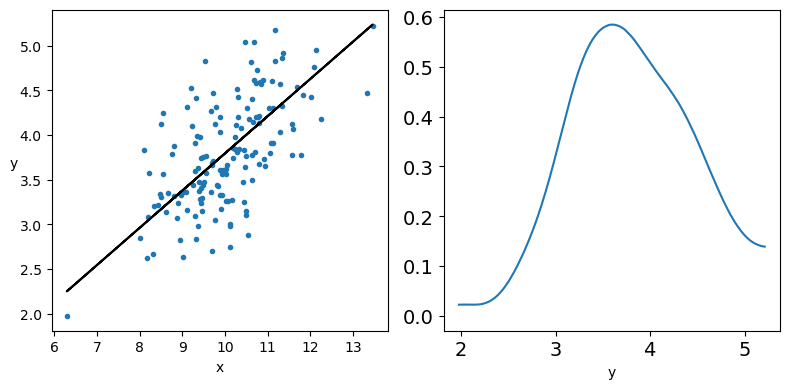

In [7]:
import matplotlib.pyplot as plt
import numpy as np

#-----------------------------------------------------------------------------------

# Showing linear relationship between the dataset of petal_lenth and petal_width

#-----------------------------------------------------------------------------------

# loading values into datasets
data=df['petal_length'].to_numpy()
data2=df['petal_width'].to_numpy()

# Size of datasets
N = 150

# fit a linear regression model to the data
beta, alpha = np.polyfit(data, data2, 1)

# Plotting a linear linear line
x = np.random.normal(10, 1, N)
y_real = alpha + beta * x
eps_real = np.random.normal(0, 0.5, size=N)
y = y_real + eps_real


_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()

# show the plot
plt.show()


In [8]:
#------------------------------------

# Using normal gaussian model 

#------------------------------------

with pm.Model() as model_g:
    
    # defining priors
    α = pm.Normal('α', mu=0, sd=20)
    β = pm.Normal('β', mu=0, sd=2)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = pm.Deterministic('μ', α + β * x)
    
    # defining likelihood 
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    idata_g = pm.sample(2000, tune=2000, start={'α': 0, 'β': 0}, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.


array([[<AxesSubplot: title={'center': 'α'}>,
        <AxesSubplot: title={'center': 'α'}>],
       [<AxesSubplot: title={'center': 'β'}>,
        <AxesSubplot: title={'center': 'β'}>],
       [<AxesSubplot: title={'center': 'ϵ'}>,
        <AxesSubplot: title={'center': 'ϵ'}>]], dtype=object)

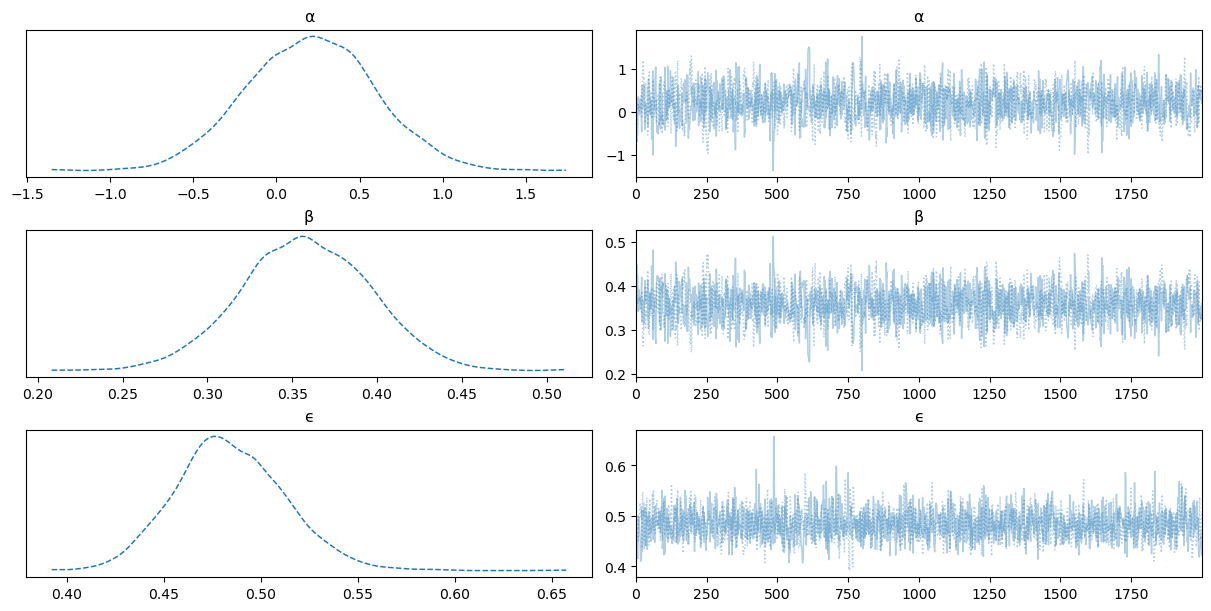

In [9]:
# Plotting the trace
az.plot_trace(idata_g, var_names=['α', 'β', 'ϵ'], combined = True)

D:\Anaconda\lib\site-packages\arviz\plots\pairplot.py:185: UserWarning: plot_kwargs will be deprecated. Please use scatter_kwargs, kde_kwargs and/or hexbin_kwargs
  warnings.warn(


<AxesSubplot: xlabel='α', ylabel='β'>

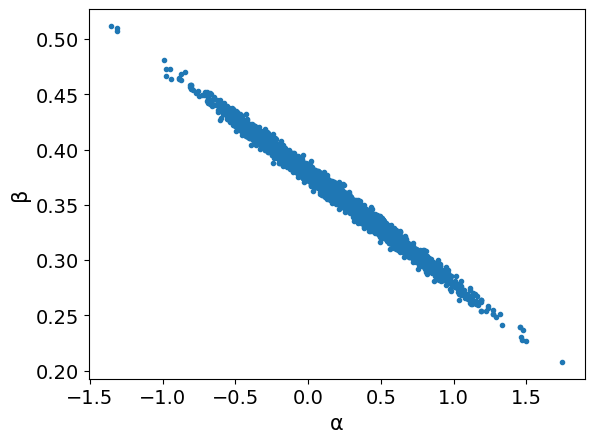

In [10]:
# Pair plot to see the co-relation between alpha and beta in normal distribution 
az.plot_pair(idata_g, var_names=['α', 'β'], plot_kwargs={'alpha': 0.1})

Value of gradient in Gaussian is:  0.3579087879498163
Value of y-intercept in Gaussian is:  0.20601258982561338


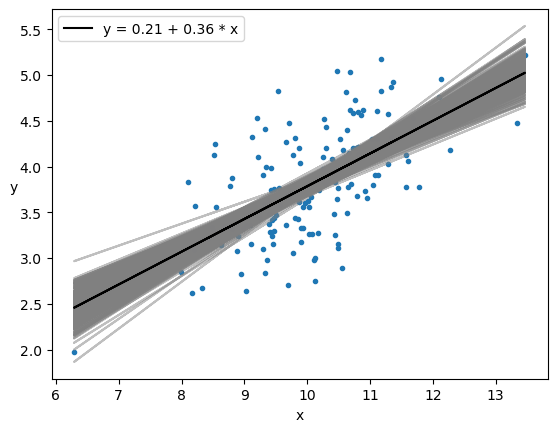

In [11]:
plt.plot(x, y, 'C0.')

# Defining posteriror for normal distribution
posterior_g = idata_g.posterior.stack(samples={"chain", "draw"})

# Calculating y-intercept and gradient. 
alpha_m = posterior_g['α'].mean().item()
beta_m = posterior_g['β'].mean().item()

# Printing values
print("Value of gradient in Gaussian is: ", beta_m)
print("Value of y-intercept in Gaussian is: ", alpha_m)

draws = range(0, posterior_g.samples.size, 10)
plt.plot(x, posterior_g['α'][draws].values + posterior_g['β'][draws].values * x[:,None], c='gray', alpha=0.5)

plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

D:\Anaconda\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


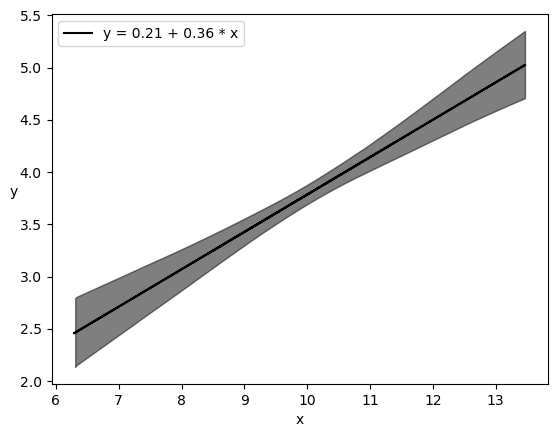

In [12]:
# hdi prob 0.98
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

sig = az.plot_hdi(x, posterior_g['μ'].T, hdi_prob=0.98, color='k')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

D:\Anaconda\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Text(0, 0.5, 'y')

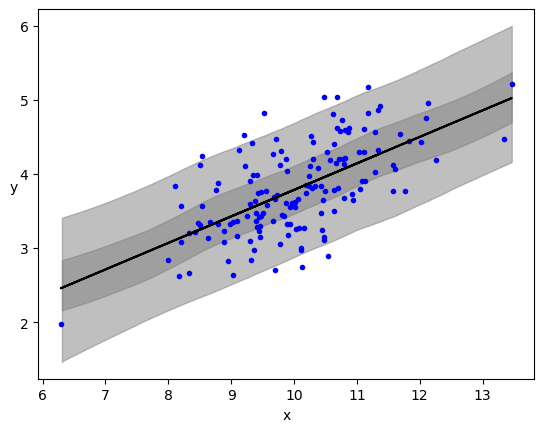

In [13]:
ppc = pm.sample_posterior_predictive(idata_g, samples=2000, model=model_g)
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

az.plot_hdi(x, ppc['y_pred'], hdi_prob=0.5, color='gray')
az.plot_hdi(x, ppc['y_pred'], color='gray')

plt.xlabel('x')
plt.ylabel('y', rotation=0)

# In the Figure below, a darker gray represents the HPD 50 and a lighter gray represents the HPD 95.

# Analysis: Most of the points are covered, but still there are many outliers even in HPD 95 so we are going to use student-T
# distribution to make our results more robust 

In [ ]:
-----------------------------------------------------------------
#Interpret and visualize the posterior 50% and 94% HDI for normal
-----------------------------------------------------------------

# HPD of the predicted data , that is, where we expect to see the 94% and 50% of future data, according to our model
# We can see that in 50% HDI interval most of the points are left out and are not covered. But when we plot the light
# grey lines for the 94% HDI it almost covers all the points but still some outliers are left. 


In [14]:
#-------------------------
# define student-t model
#-------------------------
with pm.Model() as model_t:
        
        # defining priors
        α = pm.Normal('α', mu=0, sd=20)
        β = pm.Normal('β', mu=0, sd=2)
        ϵ = pm.HalfCauchy('ϵ', 5)
        μ = pm.Deterministic('μ', α + β * x)
        
        # defining likelihood 
        y_pred = pm.StudentT('y_pred', mu=μ, sd=ϵ, nu=3, observed=y)
        
        idata_t = pm.sample(2000, tune=2000, start={'α': 0, 'β': 0}, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
The acceptance probability does not match the target. It is 0.8935499531172124, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<AxesSubplot: title={'center': 'α'}>,
        <AxesSubplot: title={'center': 'α'}>],
       [<AxesSubplot: title={'center': 'β'}>,
        <AxesSubplot: title={'center': 'β'}>],
       [<AxesSubplot: title={'center': 'ϵ'}>,
        <AxesSubplot: title={'center': 'ϵ'}>]], dtype=object)

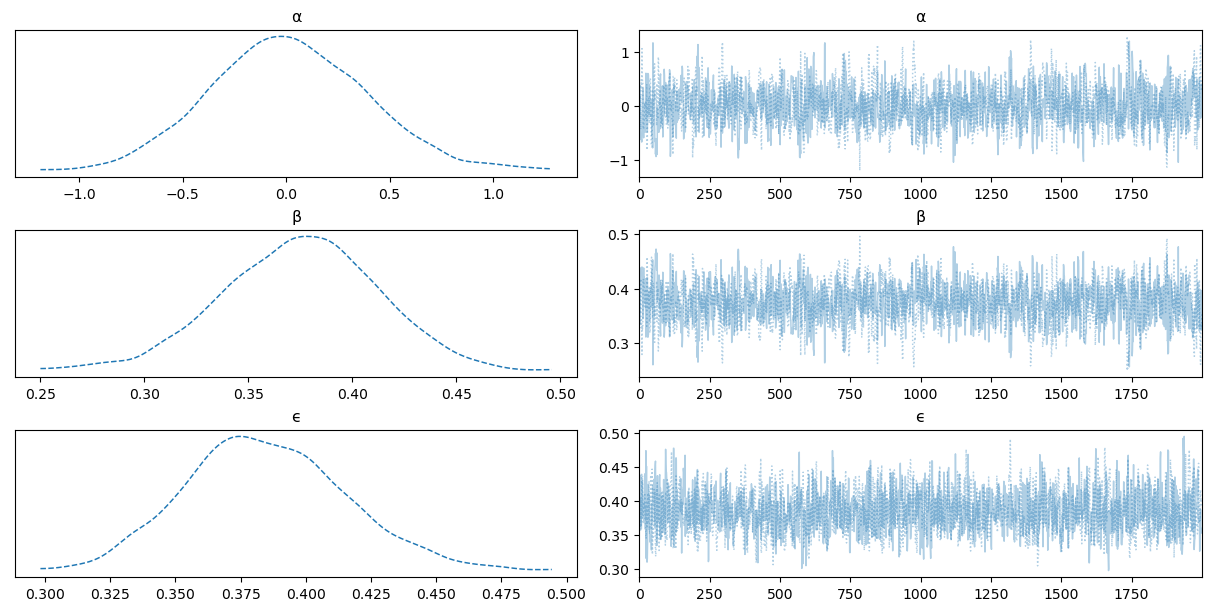

In [15]:
# ax plot trace
az.plot_trace(idata_t, var_names=['α', 'β', 'ϵ'], combined = True)

Value of gradient in Student-T is:  0.37462845904188125
Value of y-intercept in Student-T is:  0.010629358031609339


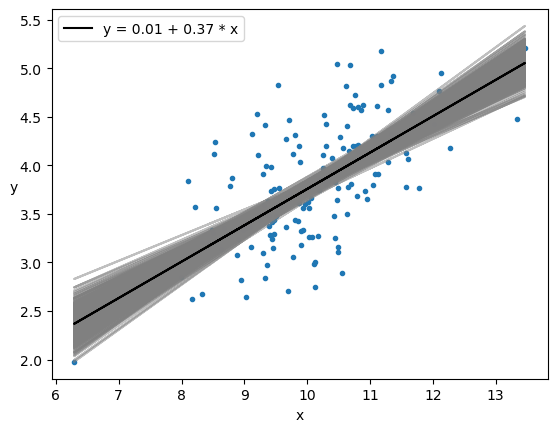

In [16]:
# draw a line for the above student-t model
posterior_t = idata_t.posterior.stack(samples={"chain", "draw"})

# calculating gradient and y-intercept for student-t
alpha_m = posterior_t['α'].mean().item()
beta_m = posterior_t['β'].mean().item()

print("Value of gradient in Student-T is: ", beta_m)
print("Value of y-intercept in Student-T is: ", alpha_m)

# plot the line
plt.plot(x, y, 'C0.')
draws = range(0, posterior_t.samples.size, 10)
plt.plot(x, posterior_t['α'][draws].values + posterior_t['β'][draws].values * x[:,None], c='gray', alpha=0.5)

plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()
    

D:\Anaconda\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


D:\Anaconda\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


Text(0, 0.5, 'y')

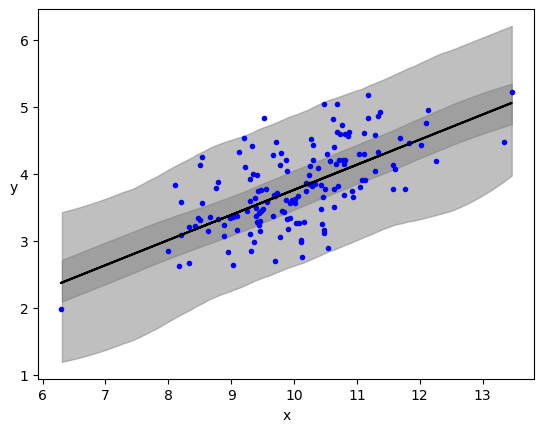

In [17]:
ppc = pm.sample_posterior_predictive(idata_t, samples=2000, model=model_t)
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

az.plot_hdi(x, ppc['y_pred'], hdi_prob=0.5, color='gray')
az.plot_hdi(x, ppc['y_pred'], color='gray')

plt.xlabel('x')
plt.ylabel('y', rotation=0)

# In the student-t we can see that it is more robust and only one point is outlier so it is far better

In [ ]:
-----------------------------------------------------------------
#Interpret and visualize the posterior 50% and 94% HDI for Student-T
-----------------------------------------------------------------

# HPD of the predicted data , that is, where we expect to see the 94% and 50% of future data, according to our model
# We can see that in 50% HDI interval for student-t more points than normal are covered. But when we plot the light
# grey lines for the 94% HDI it almost covers all the points with no outliers left or 1 outlier left.

In [17]:
#-------------------------------------------------------------------------
# Analysis to compare compare both results and writing final findings.
#-------------------------------------------------------------------------


#The key differences between the normal Gaussian model and the student-t distribution is that the student-t distribution 
#has more degrees of freedom than the normal distribution. This means that the student-t distribution is better able to handle 
#data with outliers, as it is less sensitive to extreme values. The reason for this is that the student-t distribution has 
#heavier tails, which allows for more extreme values to occur.

#In summary, while the normal Gaussian model is a widely used probability distribution, it may not be robust to outliers 
#in the data. The student-t distribution, on the other hand, is more robust to outliers, 
#making it a better choice when dealing with small sample sizes or when the population variance is unknown.


D:\Anaconda\lib\site-packages\arviz\plots\pairplot.py:185: UserWarning: plot_kwargs will be deprecated. Please use scatter_kwargs, kde_kwargs and/or hexbin_kwargs
  warnings.warn(


<AxesSubplot: xlabel='α', ylabel='β'>

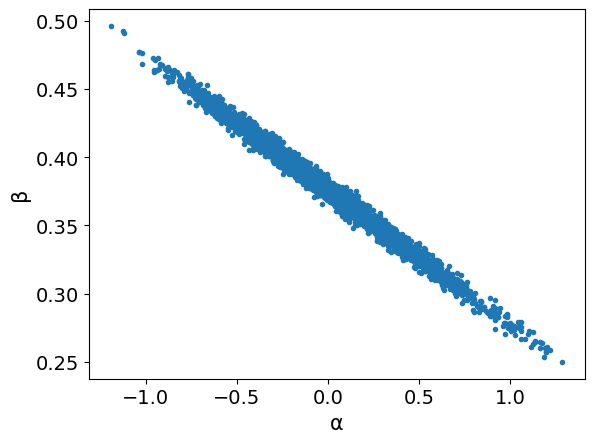

In [18]:
az.plot_pair(idata_t, var_names=['α', 'β'], plot_kwargs={'alpha': 0.1})

In [20]:
# High auto-corelation exisits. And it does so we are going to remove it
# Method used: One simple way to remove the correlation of and is to center the variable. 
# For each data point, we subtract the mean of the variable

In [19]:
x_3 = data # petal length
y_3 = data2 # petal width

# removing high auto-correlation

x_3 = x_3 - x_3.mean() 
y_3 = y_3 - y_3.mean()


In [20]:
with pm.Model() as model_robust:
    α = pm.Normal('α', mu=y_3.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1)

    y_pred = pm.StudentT('y_pred', mu=α + β * x_3,
                         sd=ϵ, nu=ν, observed=y_3)

    idata_robust = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_, ϵ, β, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 30 seconds.


D:\Anaconda\lib\site-packages\arviz\plots\pairplot.py:185: UserWarning: plot_kwargs will be deprecated. Please use scatter_kwargs, kde_kwargs and/or hexbin_kwargs
  warnings.warn(


<AxesSubplot: xlabel='α', ylabel='β'>

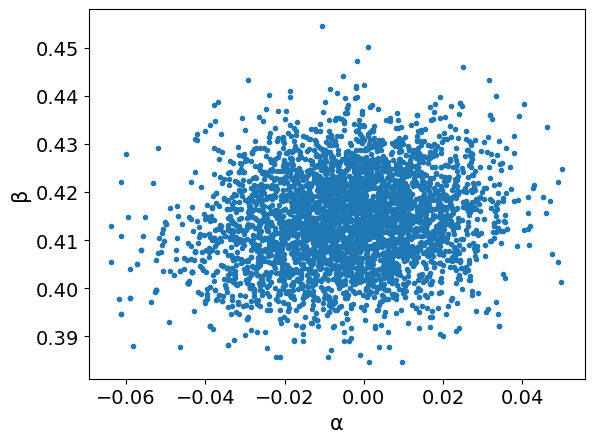

In [21]:
# pair plot
az.plot_pair(idata_robust, var_names=['α', 'β'], plot_kwargs={'alpha': 0.1})

In [ ]:
# In the above result we can see that high auto-correaltion is removed to greate extent.